In [24]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
from scipy.integrate import simps
import matplotlib.pyplot as plt
import imageio
import multiprocessing
from scipy import integrate
from helpers import Fy, find_closest_element, get_densities, get_cdf
import statsmodels.api as sm

In [25]:
# read in val data
B_zeta = np.load('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/B_zeta_val.npy')
true_y = np.load('../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/Bzeta/labels_val.npy')

density_path = '../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [26]:
# estimate density 
kde = sm.nonparametric.KDEUnivariate(true_y)
kde.fit()
support = kde.support
endog = kde.endog
density_gauss = kde.density

In [27]:
no_points = 16384
grid = support #np.linspace(min(density['axes']), max(density['axes']), no_points)
density_y = density['axes']
density_pdf = density['pdf']
# compute these beforehand to save computation time
p_y_y0 = [density_pdf[find_closest_element(y_i,density_y)] for y_i in grid]
part_1 = np.array([norm.ppf(Fy(y_i, density)) for y_i in grid])
phi_1_z = np.array([norm(0, 1).pdf(y_i) for y_i in part_1 ])

## True Density

In [28]:
grid = np.array([i for i in range(0, support.shape[0])])
def f_integral(i):
    return(integrate.trapz(density_gauss[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, grid)
cdf = np.cumsum(np.array(probs))

# VA + Ridge + Precise

In [29]:
va_ridge_dir = '../../../data/commaai/va/filtered_gaussian_resampled/Ridge/'
mu_t_va = np.genfromtxt(va_ridge_dir + 'mu_t_va.csv', delimiter = ',')
iteration = mu_t_va.shape[0]
beta_va = np.mean(mu_t_va[int(0.9*iteration):iteration,0:10], axis = 0)
tau_sq_va = np.exp(np.mean(mu_t_va[int(0.9*iteration):iteration,10], axis = 0))
p = len(beta_va)

In [30]:
no_points = 16384
grid = np.linspace(min(density['axes']), max(density['axes']), no_points)
densities_va = get_densities(B_zeta, support, p_y_y0, part_1, phi_1_z, beta_va, tau_sq_va, p,  'va_ridge', None)

100%|██████████| 10472/10472 [01:48<00:00, 96.57it/s] 


In [31]:
av_density_va = np.mean(np.array(densities_va), axis = 0)

In [32]:
def f_integral(i):
    return(integrate.trapz(av_density_va[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
cdf_va = np.cumsum(np.array(probs))

In [33]:
densities_va
cdf_va_is = []
j = 0
for supp in tqdm(densities_va):
    dens = densities_va[j]
    def f_integral(i):
        return(integrate.trapz(dens[i:(i+2)], support[i:(i+2)]))
    with multiprocessing.Pool(20) as proc:
        probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
    cdf_va_i = np.cumsum(np.array(probs))
    cdf_va_is.append(cdf_va_i)
    j += 1

100%|██████████| 10472/10472 [11:00:27<00:00,  3.78s/it] 


In [34]:
cdf_va_is = np.array(cdf_va_is)

In [35]:
np.save('../../../data/commaai/calibration/marginal_calibration/cdf_va_ridge_dens.npy', cdf_va_is)

# HMC + Ridge + Precise

In [36]:
hmc_ridge_dir = '../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/'

In [37]:
hmc_thetas = np.load(str(hmc_ridge_dir + 'all_thetas_L100_3000.npy'))[1000:, :]

In [38]:
beta_hmc = np.mean(hmc_thetas[:,0:10], axis = 0)
taus_sq_hmc = np.exp(hmc_thetas[:,10])

In [39]:
def get_densities(B_zeta, grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, p, method, Lambda):
    densities_va = []
    for i in tqdm(range(0, B_zeta.shape[0])):
        dens = predict_single_density(B_zeta[i].reshape(p,), grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, method)
        densities_va.append(dens)
    return(densities_va)

def predict_single_density(x, grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, method):
    
    psi_x0 = x

    f_eta_x0 = psi_x0.dot(beta)

    if method == 'va_ridge':
        s_0_hat = (1 + tau_sq*psi_x0.dot(psi_x0))**(-0.5)
    
    elif method == 'hmc_ridge':
        s_0_hat_js = []
        for tau_j in tau_sq:
            s_0_hat_j = (1 + tau_j*psi_x0.dot(psi_x0))**(-0.5)
            s_0_hat_js.append(s_0_hat_j)
        s_0_hat = np.mean(np.array(s_0_hat_js))

    elif method == 'va_horseshoe' or method == 'hmc_horseshoe':
        s_0_hat = (1 + (psi_x0*Lambda**2).dot(psi_x0))**(-0.5)

    part_0 = s_0_hat*f_eta_x0

    # compute the cdf of new ys
    term_1 = norm(0, 1).pdf((part_1- part_0) / s_0_hat)
    p_y_single_obs_whole_dens = (p_y_y0/phi_1_z)*(1/s_0_hat)*term_1

    return(p_y_single_obs_whole_dens)

In [40]:
p =10
densities_hmc = get_densities(B_zeta, support, p_y_y0, part_1, phi_1_z, beta_hmc, taus_sq_hmc, p,  'hmc_ridge', None)

100%|██████████| 10472/10472 [04:15<00:00, 40.95it/s]


In [41]:
av_density_hmc = np.mean(np.array(densities_hmc), axis = 0)

In [16]:
def f_integral(i):
    return(integrate.trapz(av_density_hmc[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as proc:
    probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
cdf_hmc = np.cumsum(np.array(probs))

In [42]:
densities_va
cdf_va_is = []
j = 0
for supp in tqdm(densities_va):
    dens = densities_hmc[j]
    def f_integral(i):
        return(integrate.trapz(dens[i:(i+2)], support[i:(i+2)]))
    with multiprocessing.Pool(20) as proc:
        probs = proc.map(f_integral, np.array([i for i in range(0, grid.shape[0])]))
    cdf_va_i = np.cumsum(np.array(probs))
    cdf_va_is.append(cdf_va_i)
    j += 1

100%|██████████| 10472/10472 [12:54:19<00:00,  4.44s/it] 


In [43]:
cdf_va_is = np.array(cdf_va_is)

In [44]:
np.save('../../../data/commaai/calibration/marginal_calibration/cdf_hmc_ridge_dens.npy', cdf_va_is)

# Assess marginal calibration

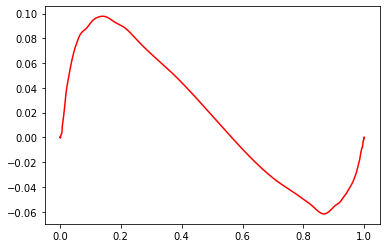

In [20]:
plt.plot(cdf, cdf_hmc - cdf, 'red')
#plt.plot(cdf, cdf_va, 'blue')

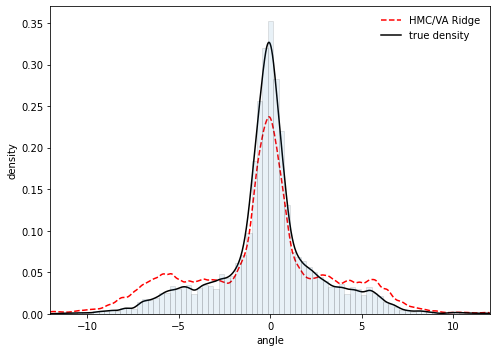

In [23]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

# Plot the histrogram
ax.hist(true_y, bins=300, density=True,
        zorder=5, edgecolor='k', alpha=0.1)
ax.plot(support, av_density_hmc, color = 'red', linestyle= '--', label = 'HMC/VA Ridge')
ax.plot(support, density_gauss, color = 'black', label = 'true density')
ax.set_xlim(-12,12)
ax.legend()
plt.legend(framealpha=0.0)
plt.xlabel('angle')
plt.ylabel('density')
plt.tight_layout()
plt.savefig('../../../data/commaai/calibration/marginal_calibration/marginal_calibration_ridge.png', dpi = 900) 

In [22]:
df_ridge = pd.DataFrame({'support': support,
             'density_hmc': av_density_hmc,
             'density_gauss': density_gauss, 
             'cdf_hmc': cdf_hmc})
df_ridge.to_csv('../../../data/commaai/calibration/marginal_calibration/ridge_prior_calibration.csv')

In [ ]:
z_pred = B_zeta.dot(beta_hmc)
y_pred = []
for z in z_pred:
    y_pred.append(density.loc[find_closest_element(float(norm.cdf(z)), density['cdf']), 'axes'])

In [ ]:
plt.scatter(true_y, y_pred, alpha = 0.2)

In [ ]:
plt.plot(cdf, cdf_hmc - cdf)

In [ ]:
# VA + Ridge + Imprecise

In [ ]:
va_ridge_dir = '../../../data/commaai/va/unfiltered_gaussian_resampled/Ridge/'
mu_t_va_impr = np.genfromtxt(va_ridge_dir + 'mu_t_va.csv', delimiter = ',')
beta_va_impr = mu_t_va_impr[0:10]
tau_sq_va_impr = np.exp(mu_t_va_impr[10])
p = 10

In [ ]:
densities_va_impr = get_densities(B_zeta, support, p_y_y0, part_1, phi_1_z, beta_va_impr, tau_sq_va_impr, p, 'va_ridge', None)

In [ ]:
plt.plot(densities_va[0], grid)

In [ ]:
av_density_ridge_impr = np.mean(np.array(densities_va_impr), axis = 0)

In [ ]:
def f_integral(i):
    return(integrate.trapz(av_density_ridge_impr[i:(i+2)], support[i:(i+2)]))
with multiprocessing.Pool(20) as p:
    probs = p.map(f_integral, grid)
cdf_va_im = np.cumsum(np.array(probs))

In [ ]:
plt.plot(cdf, (cdf_va - cdf))

In [ ]:
plt.plot(cdf_va, cdf)
plt.plot([0,1], [0,1])
plt.ylim(0,1)
plt.xlim(0,1)

In [ ]:
plt.plot(support, density_gauss, 'red')
#plt.plot(support, av_density_ridge_impr, 'yellow')
plt.plot(support, av_density_va, 'blue')


In [ ]:
plt.plot(density['axes'], density['pdf'], 'red')
plt.plot(support, density_gauss,  'blue')
#plt.plot(support, av_density_ridge_impr, 'yellow')
#plt.plot(support, av_density_va, 'blue')

In [ ]:
density

In [ ]:
# VA + Horseshoe + Precise

In [ ]:
va_ridge_dir = '../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/'
mu_t_va_horse_pr =  np.mean(np.load(va_ridge_dir + 'mu_ts_delete.npy')[20000:,:,:], axis = 0)
beta_va_horse_pr = mu_t_va_horse_pr[0:10]
tau_sq_va_horse_pr = np.exp(mu_t_va_horse_pr[10])
p = 10

In [ ]:
va_horse = np.load(va_ridge_dir + 'mu_ts_delete.npy')

In [ ]:
va_horse.shape

In [ ]:
densities_va_horse_pr = get_densities(B_zeta, grid, p_y_y0, part_1, phi_1_z, beta_va_horse_pr, tau_sq_va_horse_pr, p, 'va_ridge', None)

In [ ]:
av_density_va_horse_pr = np.mean(np.array(densities_va_horse_pr), axis = 0)

In [ ]:
df = pd.DataFrame({'grid': grid, 
              'va_ridge_pr': av_density_va,
              'va_ridge_impr': av_density_ridge_impr,
              'va_horse_impr': av_density_va_horse_pr})

In [ ]:
df.to_csv('marginal_calibration.csv')
np.savetxt("true_y.csv", true_y, delimiter=",")

In [ ]:
plt.plot(grid, av_density_va)
plt.plot(grid, av_density_ridge_impr)
plt.plot(grid, av_density_va_horse_pr)